<a href="https://colab.research.google.com/github/DoclDai/MPC_TrackReference/blob/main/MPC_Track_Reference_Zaowei_Dai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


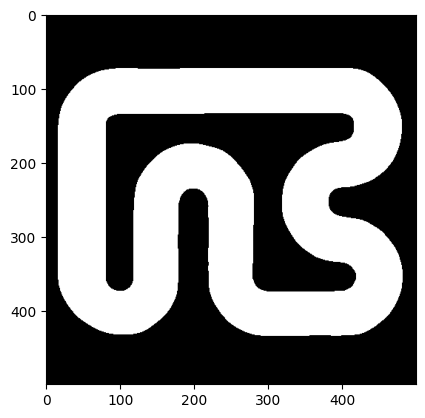

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes
from PIL import Image
from skimage.draw import line_aa
import matplotlib.patches as plt_patches
import random
# Colors
OBSTACLE = '#2E4053'


############
# Obstacle #
############

class Obstacle:
    def __init__(self, cx, cy, radius):
        """
        Constructor for a circular obstacle to be placed on a map.
        :param cx: x coordinate of center of obstacle in world coordinates
        :param cy: y coordinate of center of obstacle in world coordinates
        :param radius: radius of circular obstacle in m
        """
        self.cx = cx
        self.cy = cy
        self.radius = radius

    def show(self):
        """
        Display obstacle on current axis.
        """

        # Draw circle
        circle = plt_patches.Circle(xy=(self.cx, self.cy), radius=
                                        self.radius, color=OBSTACLE, zorder=20)
        ax = plt.gca()
        ax.add_patch(circle)


#######
# Map #
#######

class Map:
    def __init__(self, file_path, origin, resolution, threshold_occupied=100):
        """
        Constructor for map object. Map contains occupancy grid map data of
        environment as well as meta information.
        :param file_path: path to image of map
        :param threshold_occupied: threshold value for binarization of map
        image
        :param origin: x and y coordinates of map origin in world coordinates
        [m]
        :param resolution: resolution in m/px
        """

        # Set binarization threshold
        self.threshold_occupied = threshold_occupied

        # Numpy array containing map data
        self.data = np.array(Image.open(file_path))[:, :, -1]


        # Process raw map image
        self.process_map()

        # Store meta information
        self.height = self.data.shape[0]  # height of the map in px
        self.width = self.data.shape[1]  # width of the map in px
        self.resolution = resolution  # resolution of the map in m/px
        self.origin = origin  # x and y coordinates of map origin
        # (bottom-left corner) in m

        # Containers for user-specified additional obstacles and boundaries
        self.obstacles = list()
        self.boundaries = list()

    def w2m(self, x, y):
        """
        World2Map. Transform coordinates from global coordinate system to
        map coordinates.
        :param x: x coordinate in global coordinate system
        :param y: y coordinate in global coordinate system
        :return: discrete x and y coordinates in px
        """
        dx = int(np.floor((x - self.origin[0]) / self.resolution))
        dy = int(np.floor((y - self.origin[1]) / self.resolution))

        return dx, dy

    def m2w(self, dx, dy):
        """
        Map2World. Transform coordinates from map coordinate system to
        global coordinates.
        :param dx: x coordinate in map coordinate system
        :param dy: y coordinate in map coordinate system
        :return: x and y coordinates of cell center in global coordinate system
        """
        x = (dx + 0.5) * self.resolution + self.origin[0]
        y = (dy + 0.5) * self.resolution + self.origin[1]

        return x, y

    def process_map(self):
        """
        Process raw map image. Binarization and removal of small holes in map.
        """

        # Binarization using specified threshold
        # 1 corresponds to free, 0 to occupied
        self.data = np.where(self.data >= self.threshold_occupied, 1, 0)

        # Remove small holes in map corresponding to spurious measurements
        self.data = remove_small_holes(self.data, area_threshold=5,
                                       connectivity=8).astype(np.int8)

    def add_obstacles(self, obstacles):
        """
        Add obstacles to the map.
        :param obstacles: list of obstacle objects
        """

        # Extend list of obstacles
        self.obstacles.extend(obstacles)

        # Iterate over list of new obstacles
        for obstacle in obstacles:

            # Compute radius of circular object in pixels
            radius_px = int(np.ceil(obstacle.radius / self.resolution))
            # Get center coordinates of obstacle in map coordinates
            cx_px, cy_px = self.w2m(obstacle.cx, obstacle.cy)

            # Add circular object to map
            y, x = np.ogrid[-radius_px: radius_px, -radius_px: radius_px]
            index = x ** 2 + y ** 2 <= radius_px ** 2
            self.data[cy_px-radius_px:cy_px+radius_px, cx_px-radius_px:
                                                cx_px+radius_px][index] = 0

    def add_boundary(self, boundaries):
        """
        Add boundaries to the map.
        :param boundaries: list of tuples containing coordinates of boundaries'
        start and end points
        """

        # Extend list of boundaries
        self.boundaries.extend(boundaries)

        # Iterate over list of boundaries
        for boundary in boundaries:
            sx = self.w2m(boundary[0][0], boundary[0][1])
            gx = self.w2m(boundary[1][0], boundary[1][1])
            path_x, path_y, _ = line_aa(sx[0], sx[1], gx[0], gx[1])
            for x, y in zip(path_x, path_y):
                self.data[y, x] = 0

    def generate_random_obstacle(self, x, y):
        cx = random.uniform(x-0.01, x+0.01)  # Randomly generate x coordinates
        cy = random.uniform(y-0.01, y+0.01)  # Randomly generate y coordinates
        radius = random.uniform(0.05, 0.10)  # Randomly generated radius
        return Obstacle(cx, cy, radius)

if __name__ == '__main__':
    map = Map(file_path='sim_map.png', origin=(-30.0, -24.0),
                  resolution=0.06)
    # map = Map('maps/sim_map.png')
    plt.imshow(np.flipud(map.data), cmap='gray')
    plt.show()


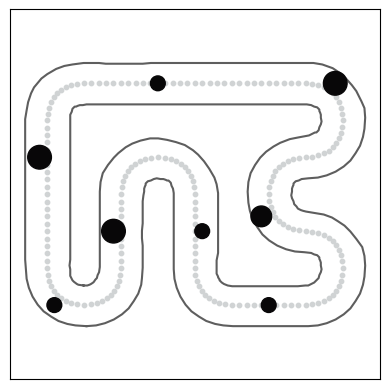

In [ ]:
import numpy as np
import math
from skimage.draw import line_aa
import matplotlib.pyplot as plt
from scipy import sparse
import osqp

# Colors
WAYPOINTS = '#D0D3D4'
OBSTACLE = '#080708'



############
# Waypoint #
############

class Waypoint:
    def __init__(self, x, y, psi, kappa):
        """
        Waypoint object containing x, y location in global coordinate system,
        orientation of waypoint psi and local curvature kappa. Waypoint further
        contains an associated reference velocity computed by the speed profile
        and a path width specified by upper and lower bounds.
        :param x: x position in global coordinate system | [m]
        :param y: y position in global coordinate system | [m]
        :param psi: orientation of waypoint | [rad]
        :param kappa: local curvature | [1 / m]
        """
        self.x = x
        self.y = y
        self.psi = psi
        self.kappa = kappa

        # Reference velocity at this waypoint according to speed profile
        self.v_ref = None

        # Information about drivable area at waypoint
        # upper and lower bound of drivable area orthogonal to
        # waypoint orientation.
        # Upper bound: free drivable area to the left of center-line in m
        # Lower bound: free drivable area to the right of center-line in m
        self.lb = None
        self.ub = None
        self.static_border_cells = None
        self.dynamic_border_cells = None

    def __sub__(self, other):
        """
        Overload subtract operator. Difference of two waypoints is equal to
        their euclidean distance.
        :param other: subtrahend
        :return: euclidean distance between two waypoints
        """
        return ((self.x - other.x)**2 + (self.y - other.y)**2)**0.5


##################
# Reference Path #
##################


class ReferencePath:
    def __init__(self, map, wp_x, wp_y, resolution, smoothing_distance,
                 max_width, circular):
        """
        Reference Path object. Create a reference trajectory from specified
        corner points with given resolution. Smoothing around corners can be
        applied. Waypoints represent center-line of the path with specified
        maximum width to both sides.
        :param map: map object on which path will be placed
        :param wp_x: x coordinates of corner points in global coordinates
        :param wp_y: y coordinates of corner points in global coordinates
        :param resolution: resolution of the path in m/wp
        :param smoothing_distance: number of waypoints used for smoothing the
        path by averaging neighborhood of waypoints
        :param max_width: maximum width of path to both sides in m
        :param circular: True if path circular
        """

        # Precision
        self.eps = 1e-12

        # Map
        self.map = map

        # Resolution of the path
        self.resolution = resolution

        # Look ahead distance for path averaging
        self.smoothing_distance = smoothing_distance

        # Circular flag
        self.circular = circular

        # List of waypoint objects
        self.waypoints = self._construct_path(wp_x, wp_y)

        # Number of waypoints
        self.n_waypoints = len(self.waypoints)

        # Length of path
        self.length, self.segment_lengths = self._compute_length()

        # Compute path width (attribute of each waypoint)
        self._compute_width(max_width=max_width)

    def _construct_path(self, wp_x, wp_y):
        """
        Construct path from given waypoints.
        :param wp_x: x coordinates of waypoints in global coordinates
        :param wp_y: y coordinates of waypoints in global coordinates
        :return: list of waypoint objects
        """

        # Number of waypoints
        n_wp = [int(np.sqrt((wp_x[i + 1] - wp_x[i]) ** 2 +
                            (wp_y[i + 1] - wp_y[i]) ** 2) /
                self.resolution) for i in range(len(wp_x) - 1)]

        # Construct waypoints with specified resolution
        gp_x, gp_y = wp_x[-1], wp_y[-1]
        wp_x = [np.linspace(wp_x[i], wp_x[i+1], n_wp[i], endpoint=False).
                    tolist() for i in range(len(wp_x)-1)]
        wp_x = [wp for segment in wp_x for wp in segment] + [gp_x]
        wp_y = [np.linspace(wp_y[i], wp_y[i + 1], n_wp[i], endpoint=False).
                    tolist() for i in range(len(wp_y) - 1)]
        wp_y = [wp for segment in wp_y for wp in segment] + [gp_y]

        # Smooth path
        wp_xs = []
        wp_ys = []
        for wp_id in range(self.smoothing_distance, len(wp_x) -
                                                    self.smoothing_distance):
            wp_xs.append(np.mean(wp_x[wp_id - self.smoothing_distance:wp_id
                                            + self.smoothing_distance + 1]))
            wp_ys.append(np.mean(wp_y[wp_id - self.smoothing_distance:wp_id
                                            + self.smoothing_distance + 1]))

        # Construct list of waypoint objects
        waypoints = list(zip(wp_xs, wp_ys))
        waypoints = self._construct_waypoints(waypoints)

        return waypoints

    def _construct_waypoints(self, waypoint_coordinates):
        """
        Reformulate conventional waypoints (x, y) coordinates into waypoint
        objects containing (x, y, psi, kappa, ub, lb)
        :param waypoint_coordinates: list of (x, y) coordinates of waypoints in
        global coordinates
        :return: list of waypoint objects for entire reference path
        """

        # List containing waypoint objects
        waypoints = []

        # Iterate over all waypoints
        for wp_id in range(len(waypoint_coordinates) - 1):

            # Get start and goal waypoints
            current_wp = np.array(waypoint_coordinates[wp_id])
            next_wp = np.array(waypoint_coordinates[wp_id + 1])

            # Difference vector
            dif_ahead = next_wp - current_wp

            # Angle ahead
            psi = np.arctan2(dif_ahead[1], dif_ahead[0])

            # Distance to next waypoint
            dist_ahead = np.linalg.norm(dif_ahead, 2)

            # Get x and y coordinates of current waypoint
            x, y = current_wp[0], current_wp[1]

            # Compute local curvature at waypoint
            # first waypoint
            if wp_id == 0:
                kappa = 0
            else:
                prev_wp = np.array(waypoint_coordinates[wp_id - 1])
                dif_behind = current_wp - prev_wp
                angle_behind = np.arctan2(dif_behind[1], dif_behind[0])
                angle_dif = np.mod(psi - angle_behind + math.pi, 2 * math.pi) \
                            - math.pi
                kappa = angle_dif / (dist_ahead + self.eps)

            waypoints.append(Waypoint(x, y, psi, kappa))

        return waypoints

    def _compute_length(self):
        """
        Compute length of center-line path as sum of euclidean distance between
        waypoints.
        :return: length of center-line path in m
        """
        segment_lengths = [0.0] + [self.waypoints[wp_id+1] - self.waypoints
                    [wp_id] for wp_id in range(len(self.waypoints)-1)]
        s = sum(segment_lengths)
        return s, segment_lengths

    def _compute_width(self, max_width):
        """
        Compute the width of the path by checking the maximum free space to
        the left and right of the center-line.
        :param max_width: maximum width of the path.
        """

        # Iterate over all waypoints
        for wp_id, wp in enumerate(self.waypoints):
            # List containing information for current waypoint
            width_info = []
            # Check width left and right of the center-line
            for i, dir in enumerate(['left', 'right']):
                # Get angle orthogonal to path in current direction
                if dir == 'left':
                    angle = np.mod(wp.psi + math.pi / 2 + math.pi,
                                 2 * math.pi) - math.pi
                else:
                    angle = np.mod(wp.psi - math.pi / 2 + math.pi,
                                   2 * math.pi) - math.pi
                # Get closest cell to orthogonal vector
                t_x, t_y = self.map.w2m(wp.x + max_width * np.cos(angle), wp.y
                                        + max_width * np.sin(angle))
                # Compute distance to orthogonal cell on path border
                b_value, b_cell = self._get_min_width(wp, t_x, t_y, max_width)
                # Add information to list for current waypoint
                width_info.append(b_value)
                width_info.append(b_cell)

            # Set waypoint attributes with width to the left and right
            wp.ub = width_info[0]
            wp.lb = -1 * width_info[2]  # minus can be assumed as waypoints
            # represent center-line of the path
            # Set border cells of waypoint
            wp.static_border_cells = (width_info[1], width_info[3])
            wp.dynamic_border_cells = (width_info[1], width_info[3])

    def _get_min_width(self, wp, t_x, t_y, max_width):
        """
        Compute the minimum distance between the current waypoint and the
        orthogonal cell on the border of the path
        :param wp: current waypoint
        :param t_x: x coordinate of border cell in map coordinates
        :param t_y: y coordinate of border cell in map coordinates
        :param max_width: maximum path width in m
        :return: min_width to border and corresponding cell
        """

        # Get neighboring cells of orthogonal cell (account for
        # discretization inaccuracy)
        tn_x, tn_y = [], []
        for i in range(-1, 2, 1):
            for j in range(-1, 2, 1):
                tn_x.append(t_x+i)
                tn_y.append(t_y+j)

        # Get pixel coordinates of waypoint
        wp_x, wp_y = self.map.w2m(wp.x, wp.y)

        # Get Bresenham paths to all possible cells
        paths = []
        for t_x, t_y in zip(tn_x, tn_y):
            x_list, y_list, _ = line_aa(wp_x, wp_y, t_x, t_y)
            paths.append(zip(x_list, y_list))

        # Compute minimum distance to border cell
        min_width = max_width
        # map inspected cell to world coordinates
        min_cell = self.map.m2w(t_x, t_y)
        for path in paths:
            for cell in path:
                t_x, t_y = cell[0], cell[1]
                # If path goes through occupied cell
                if self.map.data[t_y, t_x] == 0:
                    # Get world coordinates
                    c_x, c_y = self.map.m2w(t_x, t_y)
                    cell_dist = np.sqrt((wp.x - c_x) ** 2 + (wp.y - c_y) ** 2)
                    if cell_dist < min_width:
                        min_width = cell_dist
                        min_cell = (c_x, c_y)

        return min_width, min_cell

    def compute_speed_profile(self, Constraints):
        """
        Compute a speed profile for the path. Assign a reference velocity
        to each waypoint based on its curvature.
        :param Constraints: constraints on acceleration and velocity
        curvature of the path
        """

        # Set optimization horizon
        N = self.n_waypoints - 1

        # Constraints
        a_min = np.ones(N-1) * Constraints['a_min']
        a_max = np.ones(N-1) * Constraints['a_max']
        v_min = np.ones(N) * Constraints['v_min']
        v_max = np.ones(N) * Constraints['v_max']

        # Maximum lateral acceleration
        ay_max = Constraints['ay_max']

        # Inequality Matrix
        D1 = np.zeros((N-1, N))

        # Iterate over horizon
        for i in range(N):

            # Get information about current waypoint
            current_waypoint = self.get_waypoint(i)
            next_waypoint = self.get_waypoint(i+1)
            # distance between waypoints
            li = next_waypoint - current_waypoint
            # curvature of waypoint
            ki = current_waypoint.kappa

            # Fill operator matrix
            # dynamics of acceleration
            if i < N-1:
                D1[i, i:i+2] = np.array([-1/(2*li), 1/(2*li)])

            # Compute dynamic constraint on velocity
            v_max_dyn = np.sqrt(ay_max / (np.abs(ki) + self.eps))
            if v_max_dyn < v_max[i]:
                v_max[i] = v_max_dyn

        # Construct inequality matrix
        D1 = sparse.csc_matrix(D1)
        D2 = sparse.eye(N)
        D = sparse.vstack([D1, D2], format='csc')

        # Get upper and lower bound vectors for inequality constraints
        l = np.hstack([a_min, v_min])
        u = np.hstack([a_max, v_max])

        # Set cost matrices
        P = sparse.eye(N, format='csc')
        q = -1 * v_max

        # Solve optimization problem
        problem = osqp.OSQP()

        problem.setup(P=P, q=q, A=D, l=l, u=u, verbose=False)
        speed_profile = problem.solve().x

        # Assign reference velocity to every waypoint
        for i, wp in enumerate(self.waypoints[:-1]):
            wp.v_ref = speed_profile[i]
        self.waypoints[-1].v_ref = self.waypoints[-2].v_ref

    def get_waypoint(self, wp_id):
        """
        Get waypoint corresponding to wp_id. Circular indexing supported.
        :param wp_id: unique waypoint ID
        :return: waypoint object
        """

        # Allow circular indexing if circular path
        if wp_id >= self.n_waypoints and self.circular:
            wp_id = np.mod(wp_id, self.n_waypoints)
        # Terminate execution if end of path reached
        elif wp_id >= self.n_waypoints and not self.circular:
            print('Reached end of path!')
            exit(1)

        return self.waypoints[wp_id]

    def show(self, display_drivable_area=True):
        """
        Display path object on current figure.
        :param display_drivable_area: If True, display arrows indicating width
        of drivable area
        """

        # Clear figure
        plt.clf()

        # Disabled ticks
        plt.xticks([])
        plt.yticks([])

        # Plot map in gray-scale and set extent to match world coordinates
        canvas = np.ones(self.map.data.shape)
        # canvas = np.flipud(self.map.data)
        plt.imshow(canvas, cmap='gray',
                   extent=[self.map.origin[0], self.map.origin[0] +
                           self.map.width * self.map.resolution,
                           self.map.origin[1], self.map.origin[1] +
                           self.map.height * self.map.resolution], vmin=0.0,
                   vmax=1.0)

        # Get x and y coordinates for all waypoints
        wp_x = np.array([wp.x for wp in self.waypoints])
        wp_y = np.array([wp.y for wp in self.waypoints])

        # Plot waypoints
        # colors = [wp.v_ref for wp in self.waypoints]
        plt.scatter(wp_x, wp_y, c=WAYPOINTS, s=10)

        # Plot border of path
        bl_x = np.array([wp.static_border_cells[0][0] for wp in
                         self.waypoints] +
                        [self.waypoints[0].static_border_cells[0][0]])
        bl_y = np.array([wp.static_border_cells[0][1] for wp in
                         self.waypoints] +
                        [self.waypoints[0].static_border_cells[0][1]])
        br_x = np.array([wp.static_border_cells[1][0] for wp in
                         self.waypoints] +
                        [self.waypoints[0].static_border_cells[1][0]])
        br_y = np.array([wp.static_border_cells[1][1] for wp in
                         self.waypoints] +
                        [self.waypoints[0].static_border_cells[1][1]])

        # If circular path, connect start and end point
        if self.circular:
            plt.plot(bl_x, bl_y, color='#5E5E5E')
            plt.plot(br_x, br_y, color='#5E5E5E')
        # If not circular, close path at start and end
        else:
            plt.plot(bl_x[:-1], bl_y[:-1], color=OBSTACLE)
            plt.plot(br_x[:-1], br_y[:-1], color=OBSTACLE)
            plt.plot((bl_x[-2], br_x[-2]), (bl_y[-2], br_y[-2]), color=OBSTACLE)
            plt.plot((bl_x[0], br_x[0]), (bl_y[0], br_y[0]), color=OBSTACLE)


        # Plot obstacles
        for obstacle in self.map.obstacles:
             obstacle.show()

    def _compute_free_segments(self, wp, min_width):
        """
        Compute free path segments.
        :param wp: waypoint object
        :param min_width: minimum width of valid segment
        :return: segment candidates as list of tuples (ub_cell, lb_cell)
        """

        # Candidate segments
        free_segments = []

        # Get waypoint's border cells in map coordinates
        ub_p = self.map.w2m(wp.static_border_cells[0][0],
                            wp.static_border_cells[0][1])
        lb_p = self.map.w2m(wp.static_border_cells[1][0],
                            wp.static_border_cells[1][1])

        # Compute path from left border cell to right border cell
        x_list, y_list, _ = line_aa(ub_p[0], ub_p[1], lb_p[0], lb_p[1])

        # Initialize upper and lower bound of drivable area to
        # upper bound of path
        ub_o, lb_o = ub_p, ub_p

        # Assume occupied path
        free_cells = False

        # Iterate over path from left border to right border
        for x, y in zip(x_list[1:], y_list[1:]):
            # If cell is free, update lower bound
            if self.map.data[y, x] == 1:
                # Free cell detected
                free_cells = True
                lb_o = (x, y)
            # If cell is occupied or end of path, end segment. Add segment
            # to list of candidates. Then, reset upper and lower bound to
            # current cell.
            if (self.map.data[y, x] == 0 or (x, y) == lb_p) and free_cells:
                # Set lower bound to border cell of segment
                lb_o = (x, y)
                # Transform upper and lower bound cells to world coordinates
                ub_o = self.map.m2w(ub_o[0], ub_o[1])
                lb_o = self.map.m2w(lb_o[0], lb_o[1])
                # If segment larger than threshold, add to candidates
                if np.sqrt((ub_o[0]-lb_o[0])**2 + (ub_o[1]-lb_o[1])**2) > \
                    min_width:
                    free_segments.append((ub_o, lb_o))
                # Start new segment
                ub_o = (x, y)
                free_cells = False
            elif self.map.data[y, x] == 0 and not free_cells:
                ub_o = (x, y)
                lb_o = (x, y)

        return free_segments

    def update_path_constraints(self, wp_id, N, min_width, safety_margin):
        """
        Compute upper and lower bounds of the drivable area orthogonal to
        the given waypoint.
        """

        # container for constraints and border cells
        ub_hor = []
        lb_hor = []
        border_cells_hor = []
        border_cells_hor_sm = []

        # Iterate over horizon
        for n in range(N):

            # get corresponding waypoint
            wp = self.get_waypoint(wp_id+n)

            # Get list of free segments
            free_segments = self._compute_free_segments(wp, min_width)

            # First waypoint in horizon uses largest segment
            if n == 0:
                segment_lengths = [np.sqrt((seg[0][0]-seg[1][0])**2 +
                            (seg[0][1]-seg[1][1])**2) for seg in free_segments]
                ls_id = segment_lengths.index(max(segment_lengths))
                ub_ls, lb_ls = free_segments[ls_id]

            else:

                # Get border cells of selected segment at previous waypoint
                ub_pw, lb_pw = border_cells_hor[n-1]
                ub_pw, lb_pw = list(ub_pw), list(lb_pw)

                # Project border cells onto new waypoint in path direction
                wp_prev = self.get_waypoint(wp_id+n-1)
                delta_s = wp_prev - wp
                ub_pw[0] += delta_s * np.cos(wp_prev.psi)
                ub_pw[1] += delta_s * np.cos(wp_prev.psi)
                lb_pw[0] += delta_s * np.sin(wp_prev.psi)
                lb_pw[1] += delta_s * np.sin(wp_prev.psi)

                # Iterate over free segments for current waypoint
                if len(free_segments) >= 2:

                    # container for overlap of segments with projection
                    segment_offsets = []

                    for free_segment in free_segments:

                        # Get border cells of segment
                        ub_fs, lb_fs = free_segment

                        # distance between upper bounds and lower bounds
                        d_ub = np.sqrt((ub_fs[0]-ub_pw[0])**2 + (ub_fs[1]-ub_pw[1])**2)
                        d_lb = np.sqrt((lb_fs[0]-lb_pw[0])**2 + (lb_fs[1]-lb_pw[1])**2)
                        mean_dist = (d_ub + d_lb) / 2

                        # Append offset to projected previous segment
                        segment_offsets.append(mean_dist)

                    # Select segment with minimum offset to projected previous
                    # segment
                    ls_id = segment_offsets.index(min(segment_offsets))
                    ub_ls, lb_ls = free_segments[ls_id]

                # Select free segment in case of only one candidate
                elif len(free_segments) == 1:
                    ub_ls, lb_ls = free_segments[0]

                # Set waypoint coordinates as bound cells if no feasible
                # segment available
                else:
                    ub_ls, lb_ls = (wp.x, wp.y), (wp.x, wp.y)

            # Check sign of upper and lower bound
            angle_ub = np.mod(np.arctan2(ub_ls[1] - wp.y, ub_ls[0] - wp.x)
                                  - wp.psi + math.pi, 2 * math.pi) - math.pi
            angle_lb = np.mod(np.arctan2(lb_ls[1] - wp.y, lb_ls[0] - wp.x)
                                  - wp.psi + math.pi, 2 * math.pi) - math.pi
            sign_ub = np.sign(angle_ub)
            sign_lb = np.sign(angle_lb)

            # Compute upper and lower bound of largest drivable area
            ub = sign_ub * np.sqrt(
                    (ub_ls[0] - wp.x) ** 2 + (ub_ls[1] - wp.y) ** 2)
            lb = sign_lb * np.sqrt(
                    (lb_ls[0] - wp.x) ** 2 + (lb_ls[1] - wp.y) ** 2)

            # Subtract safety margin
            ub -= safety_margin
            lb += safety_margin

            # Check feasibility of the path
            if ub < lb:
                # Upper and lower bound of 0 indicate an infeasible path
                # given the specified safety margin
                ub, lb = 0.0, 0.0

            # Compute absolute angle of bound cell
            angle_ub = np.mod(math.pi / 2 + wp.psi + math.pi,
                                  2 * math.pi) - math.pi
            angle_lb = np.mod(-math.pi / 2 + wp.psi + math.pi,
                                  2 * math.pi) - math.pi
            # Compute cell on bound for computed distance ub and lb
            ub_ls = wp.x + ub * np.cos(angle_ub), wp.y + ub * np.sin(
                    angle_ub)
            lb_ls = wp.x - lb * np.cos(angle_lb), wp.y - lb * np.sin(
                    angle_lb)
            bound_cells_sm = (ub_ls, lb_ls)
            # Compute cell on bound for computed distance ub and lb
            ub_ls = wp.x + (ub + safety_margin) * np.cos(angle_ub), wp.y + (ub + safety_margin) * np.sin(
                angle_ub)
            lb_ls = wp.x - (lb - safety_margin) * np.cos(angle_lb), wp.y - (lb - safety_margin) * np.sin(
                angle_lb)
            bound_cells = (ub_ls, lb_ls)

            # Append results
            ub_hor.append(ub)
            lb_hor.append(lb)
            border_cells_hor.append(list(bound_cells))
            border_cells_hor_sm.append(list(bound_cells_sm))

            # Assign dynamic border cells to waypoints
            wp.dynamic_border_cells = bound_cells_sm

        return np.array(ub_hor), np.array(lb_hor), border_cells_hor_sm


if __name__ == '__main__':

    # Select Track | 'Real_Track' or 'Sim_Track'
    path = 'Sim_Track'

    if path == 'Sim_Track':

        # Load map file
        map = Map(file_path='sim_map.png', origin=[-1, -2], resolution=0.005)

        # Specify waypoints
        wp_x = [-0.75, -0.25, -0.25, 0.25, 0.25, 1.25, 1.25, 0.75, 0.75, 1.25,
                1.25, -0.75, -0.75, -0.25]
        wp_y = [-1.5, -1.5, -0.5, -0.5, -1.5, -1.5, -1, -1, -0.5, -0.5, 0, 0,
                -1.5, -1.5]

        # Specify path resolution
        path_resolution = 0.05  # m / wp

        # Create reference path
        reference_path = ReferencePath(map, wp_x, wp_y, path_resolution,
                     smoothing_distance=5, max_width=0.15,
                                       circular=True)

        # Add obstacles
        obs1 = Obstacle(cx=0.0, cy=0.0, radius=0.05)
        obs2 = Obstacle(cx=-0.8, cy=-0.5, radius=0.08)
        obs3 = Obstacle(cx=-0.7, cy=-1.5, radius=0.05)
        obs4 = Obstacle(cx=-0.3, cy=-1.0, radius=0.08)
        obs5 = Obstacle(cx=0.3, cy=-1.0, radius=0.05)
        obs6 = Obstacle(cx=0.75, cy=-1.5, radius=0.05)
        obs7 = Obstacle(cx=0.7, cy=-0.9, radius=0.07)
        obs8 = Obstacle(cx=1.2, cy=0.0, radius=0.08)
        reference_path.map.add_obstacles([obs1, obs2, obs3, obs4, obs5, obs6, obs7,
                                      obs8])

    ub, lb, border_cells = \
        reference_path.update_path_constraints(0, reference_path.n_waypoints,
                                               0.1, 0.01)
    SpeedProfileConstraints = {'a_min': -0.1, 'a_max': 0.5,
                               'v_min': 0, 'v_max': 1.0, 'ay_max': 4.0}
    reference_path.compute_speed_profile(SpeedProfileConstraints)
    # Get x and y locations of border cells for upper and lower bound
    for wp_id in range(reference_path.n_waypoints):
        reference_path.waypoints[wp_id].dynamic_border_cells = border_cells[wp_id]
    reference_path.show()
    plt.show()





In [ ]:
import numpy as np
from abc import abstractmethod
try:
    from abc import ABC
except:
    # for Python 2.7
    from abc import ABCMeta

    class ABC(object):
        __metaclass__ = ABCMeta
        pass
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
import math

# Colors
CAR = '#F1C40F'
CAR_OUTLINE = '#B7950B'


#########################
# Temporal State Vector #
#########################

class TemporalState:
    def __init__(self, x, y, psi):
        """
        Temporal State Vector containing car pose (x, y, psi)
        :param x: x position in global coordinate system | [m]
        :param y: y position in global coordinate system | [m]
        :param psi: yaw angle | [rad]
        """
        self.x = x
        self.y = y
        self.psi = psi

        self.members = ['x', 'y', 'psi']

    def __iadd__(self, other):
        """
        Overload Sum-Add operator.
        :param other: numpy array to be added to state vector
        """
        for state_id in range(len(self.members)):
            vars(self)[self.members[state_id]] += other[state_id]
        return self


########################
# Spatial State Vector #
########################

class SpatialState(ABC):
    """
    Spatial State Vector - Abstract Base Class.
    """

    @abstractmethod
    def __init__(self):
        self.members = None
        self.e_y = None
        self.e_psi = None

    def __getitem__(self, item):
        if isinstance(item, int):
            members = [self.members[item]]
        else:
            members = self.members[item]
        return [vars(self)[key] for key in members]

    def __setitem__(self, key, value):
        vars(self)[self.members[key]] = value

    def __len__(self):
        return len(self.members)

    def __iadd__(self, other):
        """
        Overload Sum-Add operator.
        :param other: numpy array to be added to state vector
        """
        for state_id in range(len(self.members)):
            vars(self)[self.members[state_id]] += other[state_id]
        return self

    def list_states(self):
        """
        Return list of names of all states.
        """
        return self.members


class SimpleSpatialState(SpatialState):
    def __init__(self, e_y=0.0, e_psi=0.0, t=0.0):
        """
        Simplified Spatial State Vector containing orthogonal deviation from
        reference path (e_y), difference in orientation (e_psi) and velocity
        :param e_y: orthogonal deviation from center-line | [m]
        :param e_psi: yaw angle relative to path | [rad]
        :param t: time | [s]
        """
        super(SimpleSpatialState, self).__init__()

        self.e_y = e_y
        self.e_psi = e_psi
        self.t = t

        self.members = ['e_y', 'e_psi', 't']


####################################
# Spatial Bicycle Model Base Class #
####################################

class SpatialBicycleModel(ABC):
    def __init__(self, reference_path, length, width, Ts):
        """
        Abstract Base Class for Spatial Reformulation of Bicycle Model.
        :param reference_path: reference path object to follow
        :param length: length of car in m
        :param width: width of car in m
        :param Ts: sampling time of model
        """

        # Precision
        self.eps = 1e-12

        # Car Parameters
        self.length = length
        self.width = width
        self.safety_margin = self._compute_safety_margin()

        # Reference Path
        self.reference_path = reference_path

        # Set initial distance traveled
        self.s = 0.0

        # Set sampling time
        self.Ts = Ts

        # Set initial waypoint ID
        self.wp_id = 0

        # Set initial waypoint
        self.current_waypoint = self.reference_path.waypoints[self.wp_id]

        # Declare spatial state variable | Initialization in sub-class
        self.spatial_state = None

        # Declare temporal state variable | Initialization in sub-class
        self.temporal_state = None

    def s2t(self, reference_waypoint, reference_state):
        """
        Convert spatial state to temporal state given a reference waypoint.
        :param reference_waypoint: waypoint object to use as reference
        :param reference_state: state vector as np.array to use as reference
        :return Temporal State equivalent to reference state
        """

        # Compute temporal state variables
        if isinstance(reference_state, np.ndarray):
            x = reference_waypoint.x - reference_state[0] * np.sin(
                reference_waypoint.psi)
            y = reference_waypoint.y + reference_state[0] * np.cos(
                reference_waypoint.psi)
            psi = reference_waypoint.psi + reference_state[1]
        elif isinstance(reference_state, SpatialState):
            x = reference_waypoint.x - reference_state.e_y * np.sin(
                reference_waypoint.psi)
            y = reference_waypoint.y + reference_state.e_y * np.cos(
                reference_waypoint.psi)
            psi = reference_waypoint.psi + reference_state.e_psi
        else:
            print('Reference State type not supported!')
            x, y, psi = None, None, None
            exit(1)

        return TemporalState(x, y, psi)

    def t2s(self, reference_waypoint, reference_state):
        """
        Convert spatial state to temporal state. Either convert self.spatial_
        state with current waypoint as reference or provide reference waypoint
        and reference_state.
        :return Spatial State equivalent to reference state
        """

        # Compute spatial state variables
        if isinstance(reference_state, np.ndarray):
            e_y = np.cos(reference_waypoint.psi) * \
                  (reference_state[1] - reference_waypoint.y) - \
                  np.sin(reference_waypoint.psi) * (reference_state[0] -
                                                    reference_waypoint.x)
            e_psi = reference_state[2] - reference_waypoint.psi

            # Ensure e_psi is kept within range (-pi, pi]
            e_psi = np.mod(e_psi + math.pi, 2 * math.pi) - math.pi
        elif isinstance(reference_state, TemporalState):
            e_y = np.cos(reference_waypoint.psi) * \
                  (reference_state.y - reference_waypoint.y) - \
                  np.sin(reference_waypoint.psi) * (reference_state.x -
                                                    reference_waypoint.x)
            e_psi = reference_state.psi - reference_waypoint.psi

            # Ensure e_psi is kept within range (-pi, pi]
            e_psi = np.mod(e_psi + math.pi, 2 * math.pi) - math.pi
        else:
            print('Reference State type not supported!')
            e_y, e_psi = None, None
            exit(1)

        # time state can be set to zero since it's only relevant for the MPC
        # prediction horizon
        t = 0.0

        return SimpleSpatialState(e_y, e_psi, t)

    def drive(self, u):
        """
        Drive.
        :param u: input vector containing [v, delta]
        """

        # Get input signals
        v, delta = u

        # Compute temporal state derivatives
        x_dot = v * np.cos(self.temporal_state.psi)
        y_dot = v * np.sin(self.temporal_state.psi)
        psi_dot = v / self.length * np.tan(delta)
        temporal_derivatives = np.array([x_dot, y_dot, psi_dot])

        # Update spatial state (Forward Euler Approximation)
        self.temporal_state += temporal_derivatives * self.Ts

        # Compute velocity along path
        s_dot = 1 / (1 - self.spatial_state.e_y * self.current_waypoint.kappa) \
                * v * np.cos(self.spatial_state.e_psi)

        # Update distance travelled along reference path
        self.s += s_dot * self.Ts

    def _compute_safety_margin(self):
        """
        Compute safety margin for car if modeled by its center of gravity.
        """

        # Model ellipsoid around the car
        safety_margin = self.width / np.sqrt(2)

        return safety_margin

    def get_current_waypoint(self):
        """
        Get closest waypoint on reference path based on car's current location.
        """

        # Compute cumulative path length
        length_cum = np.cumsum(self.reference_path.segment_lengths)
        # Get first index with distance larger than distance traveled by car
        # so far
        greater_than_threshold = length_cum > self.s
        next_wp_id = greater_than_threshold.searchsorted(True)
        # Get previous index
        prev_wp_id = next_wp_id - 1

        # Get distance traveled for both enclosing waypoints
        s_next = length_cum[next_wp_id]
        s_prev = length_cum[prev_wp_id]

        if np.abs(self.s - s_next) < np.abs(self.s - s_prev):
            self.wp_id = next_wp_id
            self.current_waypoint = self.reference_path.waypoints[next_wp_id]
        else:
            self.wp_id = prev_wp_id
            self.current_waypoint = self.reference_path.waypoints[prev_wp_id]

    def show(self):
        """
        Display car on current axis.
        """

        # Get car's center of gravity
        cog = (self.temporal_state.x, self.temporal_state.y)
        # Get current angle with respect to x-axis
        yaw = np.rad2deg(self.temporal_state.psi)
        # Draw rectangle
        car = plt_patches.Rectangle(cog, width=self.length, height=self.width,
                                    angle=yaw, facecolor=CAR,
                                    edgecolor=CAR_OUTLINE, zorder=20)

        # Shift center rectangle to match center of the car
        car.set_x(car.get_x() - (self.length / 2 *
                                 np.cos(self.temporal_state.psi) -
                                 self.width / 2 *
                                 np.sin(self.temporal_state.psi)))
        car.set_y(car.get_y() - (self.width / 2 *
                                 np.cos(self.temporal_state.psi) +
                                 self.length / 2 *
                                 np.sin(self.temporal_state.psi)))

        # Add rectangle to current axis
        ax = plt.gca()
        ax.add_patch(car)

    @abstractmethod
    def get_spatial_derivatives(self, state, input, kappa):
        pass

    @abstractmethod
    def linearize(self, v_ref, kappa_ref, delta_s):
        pass


#################
# Bicycle Model #
#################

class BicycleModel(SpatialBicycleModel):
    def __init__(self, reference_path, length, width, Ts):
        """
        Simplified Spatial Bicycle Model. Spatial Reformulation of Kinematic
        Bicycle Model. Uses Simplified Spatial State.
        :param reference_path: reference path model is supposed to follow
        :param length: length of the car in m
        :param width: with of the car in m
        :param Ts: sampling time of model in s
        """

        # Initialize base class
        super(BicycleModel, self).__init__(reference_path, length=length,
                                           width=width, Ts=Ts)

        # Initialize spatial state
        self.spatial_state = SimpleSpatialState()

        # Number of spatial state variables
        self.n_states = len(self.spatial_state)

        # Initialize temporal state
        self.temporal_state = self.s2t(reference_state=self.spatial_state,
                                       reference_waypoint=self.current_waypoint)

    def get_temporal_derivatives(self, state, input, kappa):
        """
        Compute relevant temporal derivatives needed for state update.
        :param state: state vector for which to compute derivatives
        :param input: input vector
        :param kappa: curvature of corresponding waypoint
        :return: temporal derivatives of distance, angle and velocity
        """

        # Get state and input variables
        e_y, e_psi, t = state
        v, delta = input

        # Compute velocity along path
        s_dot = 1 / (1 - (e_y * kappa)) * v * np.cos(e_psi)

        # Compute yaw angle rate of change
        psi_dot = v / self.length * np.tan(delta)

        return s_dot, psi_dot

    def get_spatial_derivatives(self, state, input, kappa):
        """
        Compute spatial derivatives of all state variables for update.
        :param state: state vector for which to compute derivatives
        :param input: input vector
        :param kappa: curvature of corresponding waypoint
        :return: numpy array with spatial derivatives for all state variables
        """

        # Get state and input variables
        e_y, e_psi, t = state
        v, delta = input

        # Compute temporal derivatives
        s_dot, psi_dot = self.get_temporal_derivatives(state, input, kappa)

        # Compute spatial derivatives
        d_e_y_d_s = v * np.sin(e_psi) / s_dot
        d_e_psi_d_s = psi_dot / s_dot - kappa
        d_t_d_s = 1 / s_dot

        return np.array([d_e_y_d_s, d_e_psi_d_s, d_t_d_s])

    def linearize(self, v_ref, kappa_ref, delta_s):
        """
        Linearize the system equations around provided reference values.
        :param v_ref: velocity reference around which to linearize
        :param kappa_ref: kappa of waypoint around which to linearize
        :param delta_s: distance between current waypoint and next waypoint
         """

        ###################
        # System Matrices #
        ###################

        # Construct Jacobian Matrix
        a_1 = np.array([1, delta_s, 0])
        a_2 = np.array([-kappa_ref ** 2 * delta_s, 1, 0])
        a_3 = np.array([-kappa_ref / v_ref * delta_s, 0, 1])

        b_1 = np.array([0, 0])
        b_2 = np.array([0, delta_s])
        b_3 = np.array([-1 / (v_ref ** 2) * delta_s, 0])

        f = np.array([0.0, 0.0, 1 / v_ref * delta_s])

        A = np.stack((a_1, a_2, a_3), axis=0)
        B = np.stack((b_1, b_2, b_3), axis=0)

        return f, A, B


MPC.py

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64



import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from pyomo.environ import *


# Colors
PREDICTION = '#0600ba'

##################
# MPC Controller #
##################


class MPC:
    def __init__(self, model, N, Q, R, QN, StateConstraints, InputConstraints,
                 ay_max):
        """
        Constructor for the Model Predictive Controller.
        :param model: bicycle model object to be controlled
        :param N: time horizon | int
        :param Q: state cost matrix
        :param R: input cost matrix
        :param QN: final state cost matrix
        :param StateConstraints: dictionary of state constraints
        :param InputConstraints: dictionary of input constraints
        :param ay_max: maximum allowed lateral acceleration in curves
        """

        # Parameters
        self.N = N  # horizon
        self.Q = Q  # weight matrix state vector
        self.R = R  # weight matrix input vector
        self.P = QN  # weight matrix terminal



        # Model
        self.model = model

        # Dimensions
        self.nx = self.model.n_states
        self.nu = 2

        # Constraints
        self.state_constraints = StateConstraints
        self.input_constraints = InputConstraints

        # Maximum lateral acceleration
        self.ay_max = ay_max

        # Current control and prediction
        self.current_prediction = None

        # Counter for old control signals in case of infeasible problem
        self.infeasibility_counter = 0

        # Current control signals
        self.current_control = np.zeros((self.nu*self.N))

        # Initialize Optimization Problem
        self.result=None

        # Storage control parameters
        self.open_loop_controls = []
        self.closed_loop_controls = []




    def _init_problem(self,zbar0):
      """
      Initialize optimization problem for current time step.

      contorl signal: u = [v, delta]
      delta is the steering angle
      v is the velocity
      state: x = [x, y, theta]
      theta is the heading angle
      """

      # Create a model
      model = ConcreteModel()

      # Define index sets
      model.N = self.N
      Ts=1


      # LTV System Matrices
      A = np.array([[1,0,0],
               [0, 1,Ts],
               [0,0,1]])
      B = np.array([[1,0],
              [0,Ts],
              [0,1]])



      # Define the state and input variables
      model.nz=np.size(A,0)
      model.nu=np.size(B,1)



      model.tIDX = Set( initialize=range(0,self.N+1), ordered=True)
      model.zIDX = Set( initialize=range(0,model.nz), ordered=True)
      model.uIDX = Set( initialize=range(0,model.nu), ordered=True)

      model.A=A
      model.B=B
      model.Q=self.Q
      model.P=self.P
      model.R=self.R

  # Create state and input variables trajectory:
      model.z=Var(model.zIDX,model.tIDX)
      model.u=Var(model.tIDX)
      for i in model.zIDX:
          for t in model.tIDX:
              model.z[i, t].setlb(self.state_constraints['xmin'])
              model.z[i, t].setub(self.state_constraints['xmax'])

      for t in model.tIDX:
        model.u[t].setlb(self.input_constraints['umin'])
        model.u[t].setub(self.input_constraints['umax'])

      def cost_rule(model):
          costX=0
          costU=0
          costTerminal=0
          for t in model.tIDX:
            for i in model.zIDX:
              for j in model.zIDX:
                if t<model.N:
                  costX+=(model.z[i,t]-zbar0[i])*model.Q[i,j]*(model.z[j,t]-zbar0[i])
          if t<model.N:
              costU+=model.u[t]*model.R*model.u[t]
          for i in model.zIDX:
            for j in model.zIDX:
              costTerminal+=(model.z[i,model.N]-zbar0[i])*model.P[i,j]*(model.z[j,model.N]-zbar0[i])

          return costX+costU+costTerminal
      model.cost = Objective(rule = cost_rule, sense = minimize)

      def equality_const_rule(model, i, t):
        return model.z[i, t+1] - (sum(model.A[i, j] * model.z[j, t] for j in model.zIDX)
                              +  model.B[i, 0] * model.u[t])  == 0.0 if t < model.N else Constraint.Skip


      model.equality_constraints = Constraint(model.zIDX, model.tIDX, rule=equality_const_rule)
      model.init_const1 = Constraint(expr = model.z[1, 0] == self.model.spatial_state.e_y)
      model.init_const2 = Constraint(expr = model.z[2, 0] == self.model.spatial_state.e_psi)



      # Get information from path constraints
      ub, lb, _ = self.model.reference_path.update_path_constraints(
                    self.model.wp_id+1, self.N, 2*self.model.safety_margin,
            self.model.safety_margin)

      for t in model.tIDX:
        if t==29:
          break
        model.z[2, t].setlb(lb[t])
        model.z[2, t].setub(ub[t])

      print("ub: ", ub)
      print("lb: ", lb)
      self.model = model

    def get_control(self):
        """
        Get control signal given the current position of the car. Solves a
        finite time optimization problem based on the linearized car model.
        """
        nx = self.model.n_states
        nu = 2

        # Update current waypoint
        self.model.get_current_waypoint()

        # Update spatial state
        self.model.spatial_state = self.model.t2s(reference_state=
            self.model.temporal_state, reference_waypoint=
            self.model.current_waypoint)

        # Initialize optimization problem
        self._init_problem(np.array([0,self.model.spatial_state.e_y,self.model.spatial_state.e_psi]) )

        # Solve optimization problem
        solver = SolverFactory('ipopt')
        results = solver.solve(self.model)

        # Extract decision variables
        dec = np.array([self.model.u[n,i].value for n in self.model.N for i in self.model.nu])
        self.open_loop_controls.append(dec)


        print("dec",dec)



        try:
            # Get control signals
            control_signals = np.array(dec.x[-self.N*nu:])
            control_signals[1::2] = np.arctan(control_signals[1::2] *
                                              self.model.length)
            v = control_signals[0]
            delta = control_signals[1]
            self.closed_loop_controls.append(control_signals[0])


            # Update control signals
            self.current_control = control_signals

            # Get predicted spatial states
            x = np.reshape(dec.x[:(self.N+1)*nx], (self.N+1, nx))

            # Update predicted temporal states
            self.current_prediction = self.update_prediction(x)

            # Get current control signal
            u = np.array([v, delta])

            # if problem solved, reset infeasibility counter
            self.infeasibility_counter = 0

        except:

            print('Infeasible problem. Previously predicted'
                  ' control signal used!')
            id = nu * (self.infeasibility_counter + 1)
            u = np.array(self.current_control[id:id+2])

            # increase infeasibility counter
            self.infeasibility_counter += 1

        if self.infeasibility_counter == (self.N - 1):
            print('No control signal computed!')
            exit(1)

        print("u: ", u)

        return u

    def update_prediction(self, spatial_state_prediction):
        """
        Transform the predicted states to predicted x and y coordinates.
        Mainly for visualization purposes.
        :param spatial_state_prediction: list of predicted state variables
        :return: lists of predicted x and y coordinates
        """

        # Containers for x and y coordinates of predicted states
        x_pred, y_pred = [], []

        # Iterate over prediction horizon
        for n in range(2, self.N):
            # Get associated waypoint
            associated_waypoint = self.model.reference_path.\
                get_waypoint(self.model.wp_id+n)
            # Transform predicted spatial state to temporal state
            predicted_temporal_state = self.model.s2t(associated_waypoint,
                                            spatial_state_prediction[n, :])

            # Save predicted coordinates in world coordinate frame
            x_pred.append(predicted_temporal_state.x)
            y_pred.append(predicted_temporal_state.y)

        return x_pred, y_pred

    def show_prediction(self):
        """
        Display predicted car trajectory in current axis.
        """

        if self.current_prediction is not None:
            plt.scatter(self.current_prediction[0], self.current_prediction[1],
                    c=PREDICTION, s=30)

        plt.figure()
        plt.plot(self.open_loop_controls, 'b--', label='Open-loop control')
        plt.plot(self.closed_loop_controls, 'g-', label='Closed-loop control')
        plt.xlabel('Time step')
        plt.ylabel('Control input')
        plt.legend()
        plt.show()





Simulation.py

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


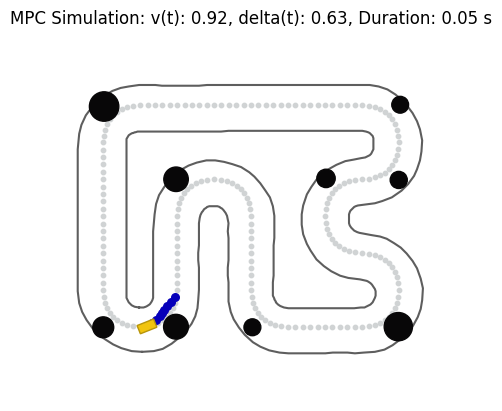

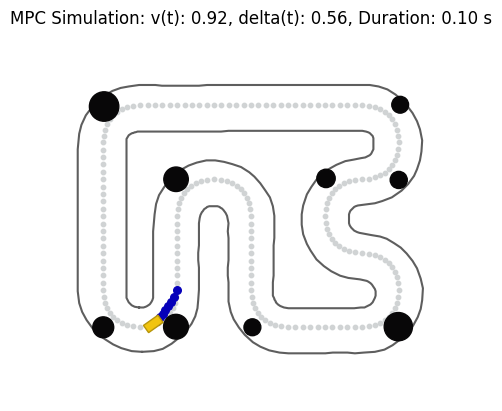

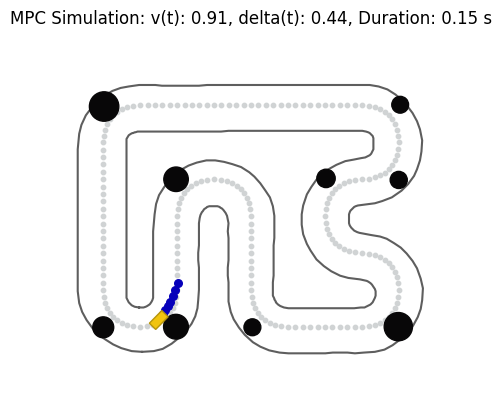

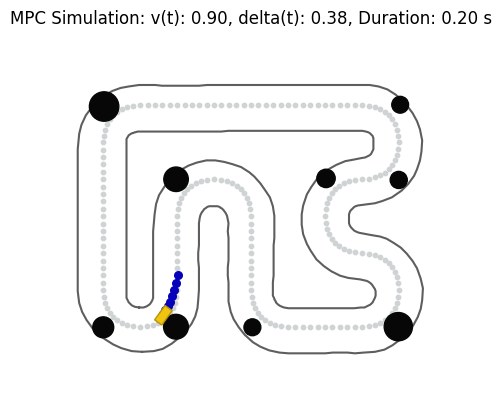

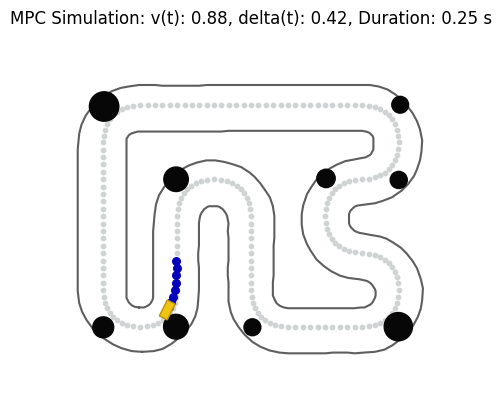

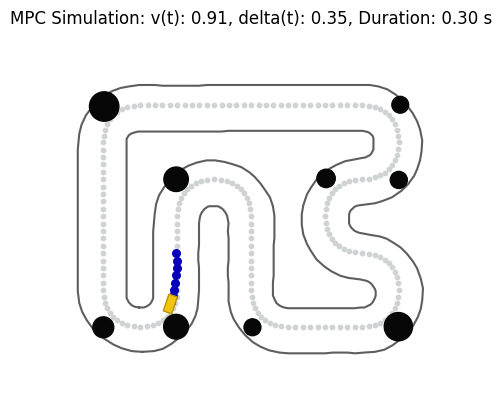

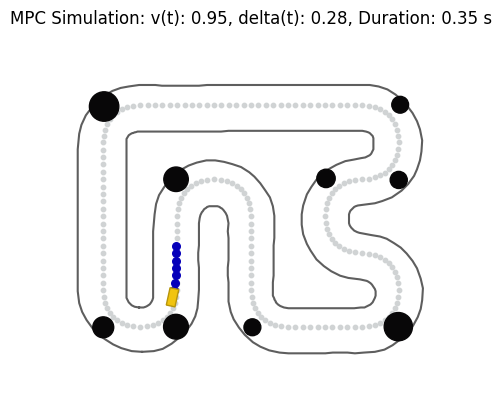

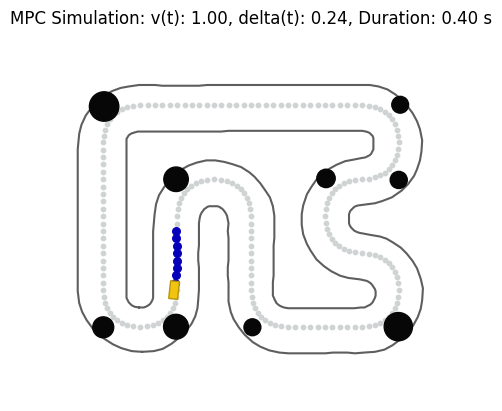

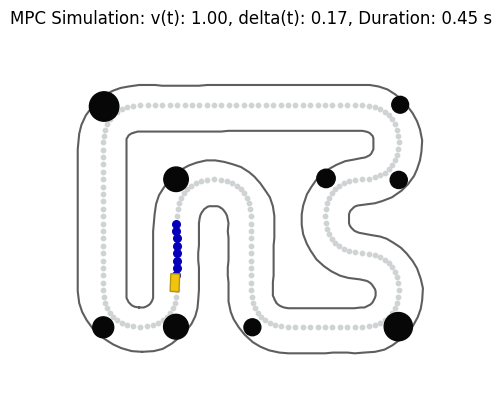

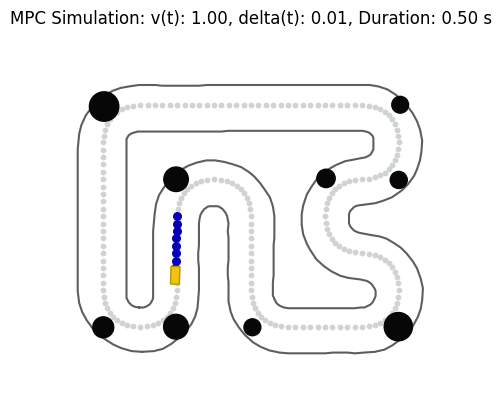

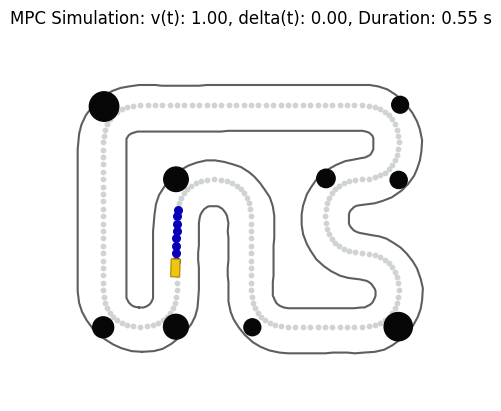

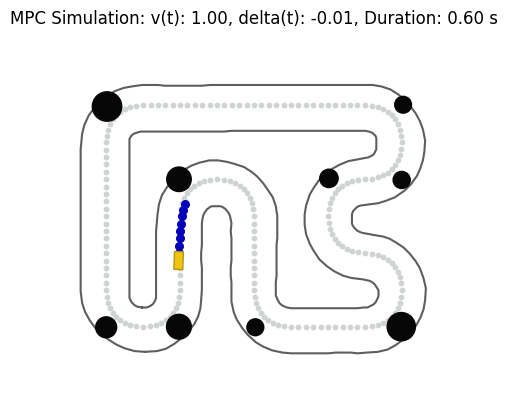

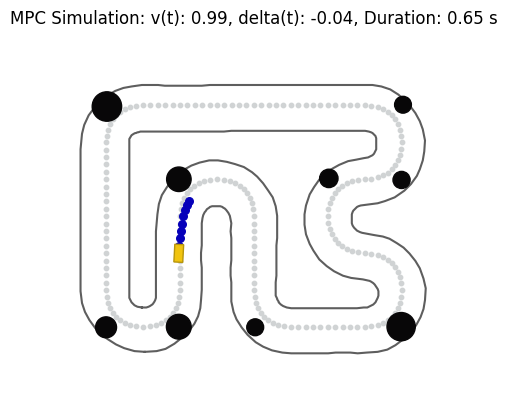

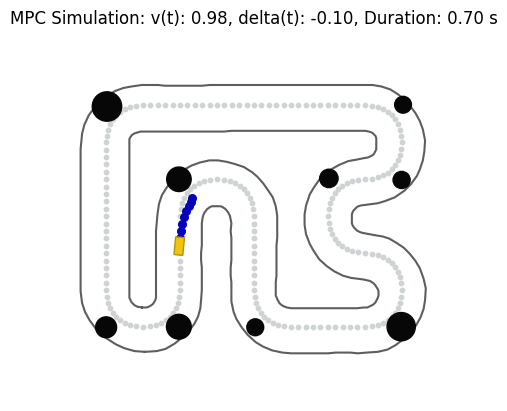

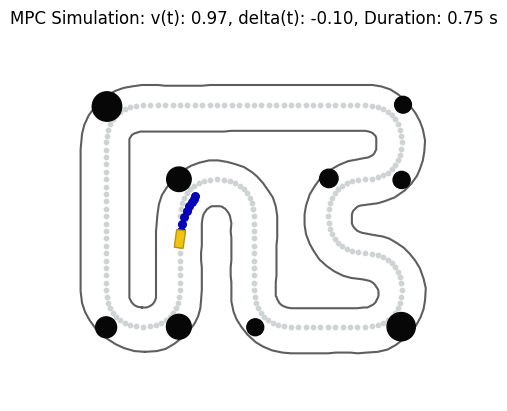

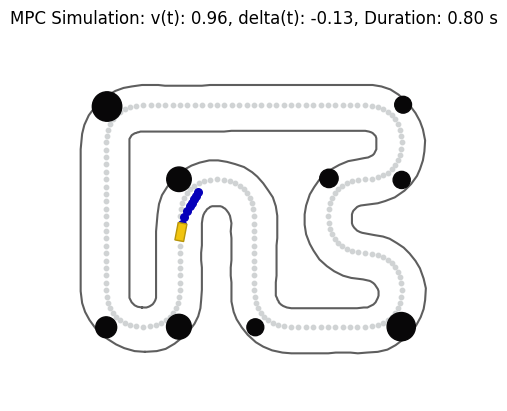

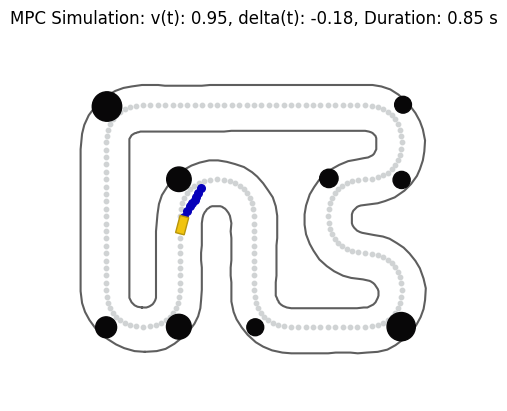

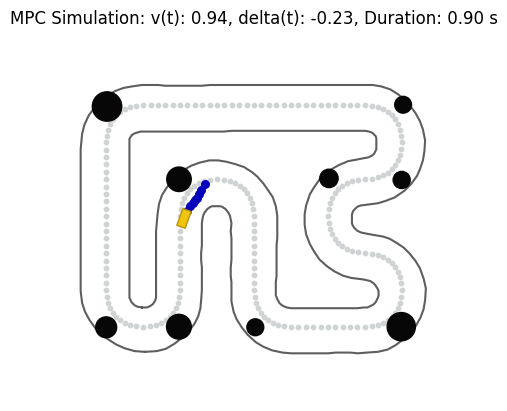

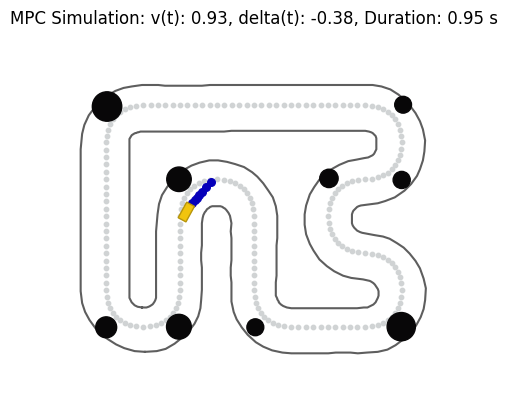

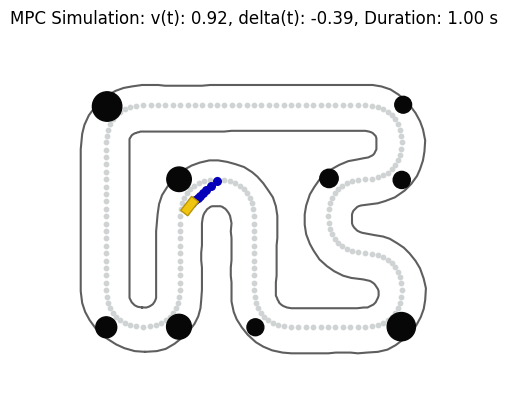

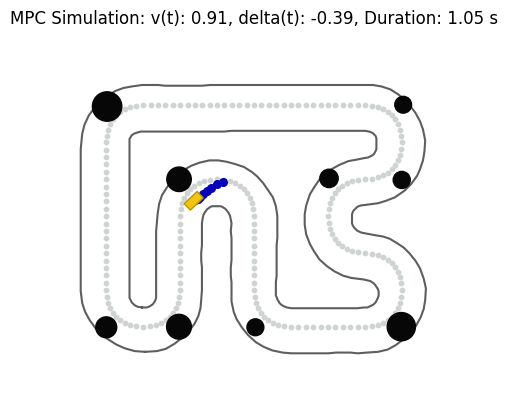

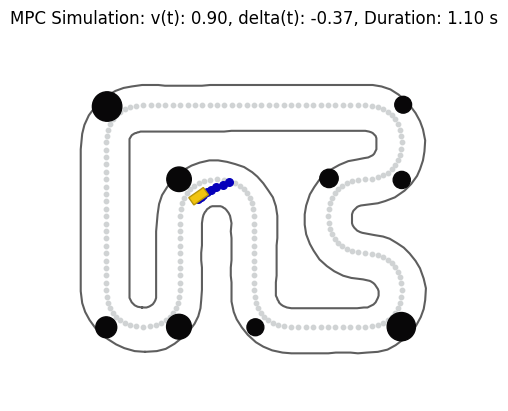

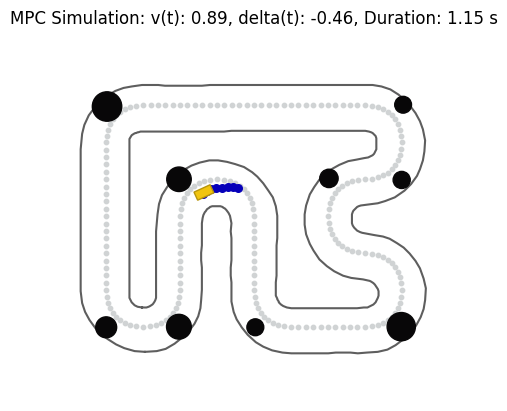

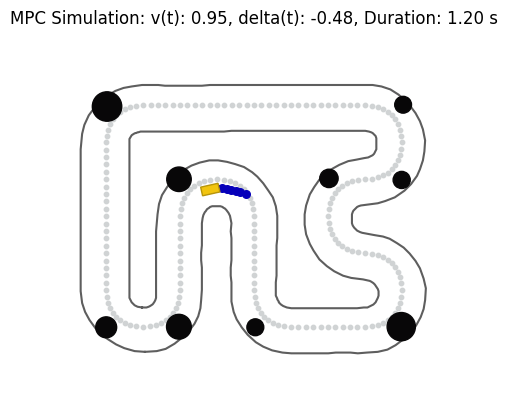

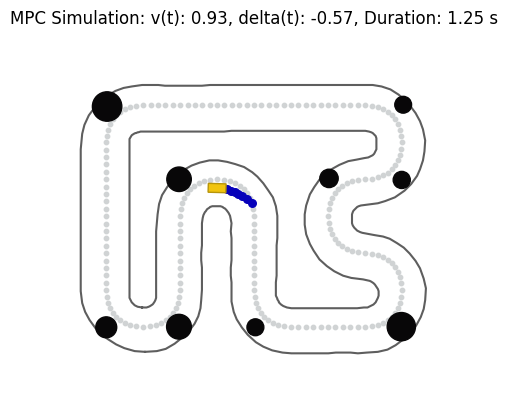

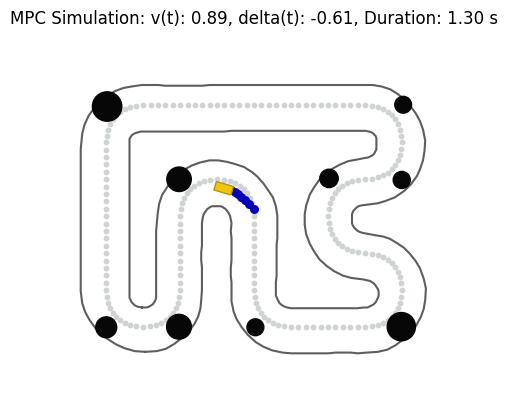

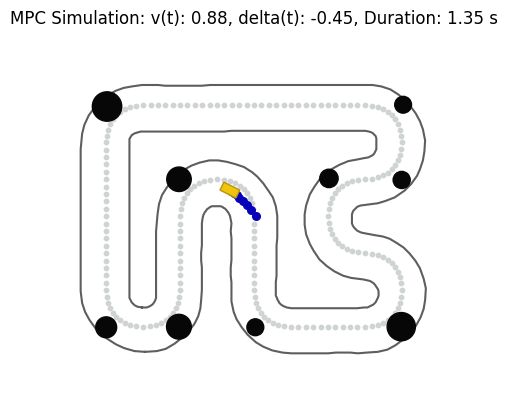

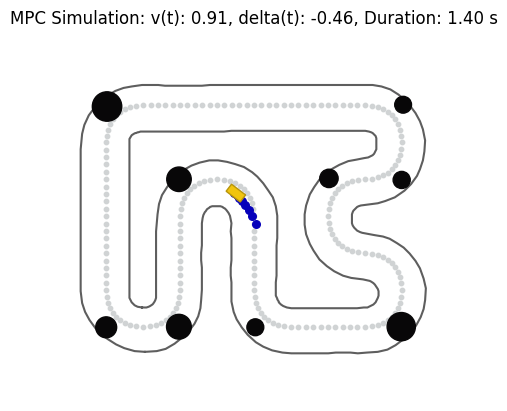

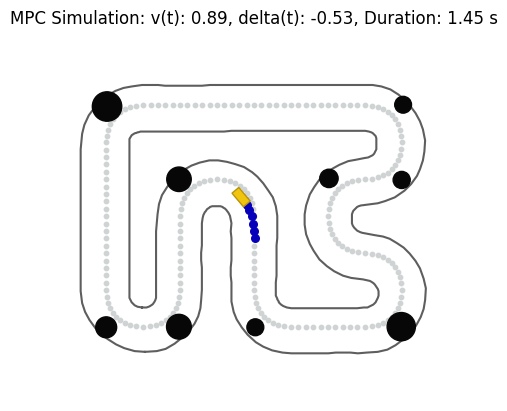

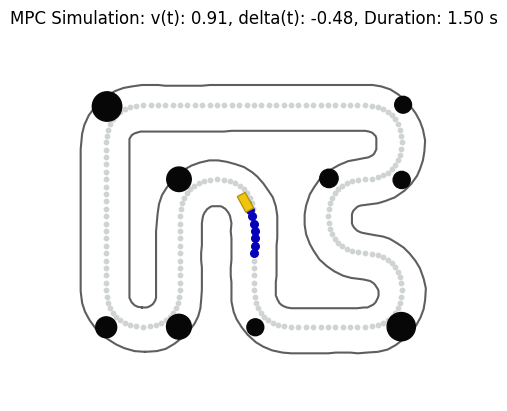

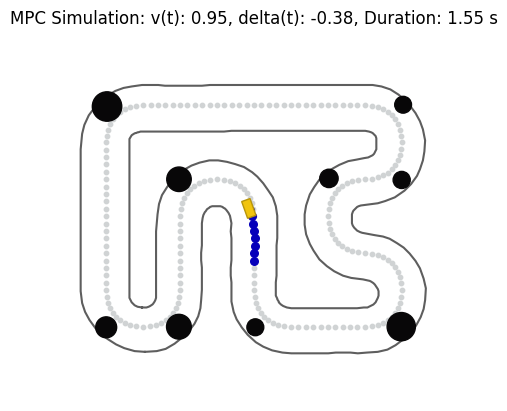

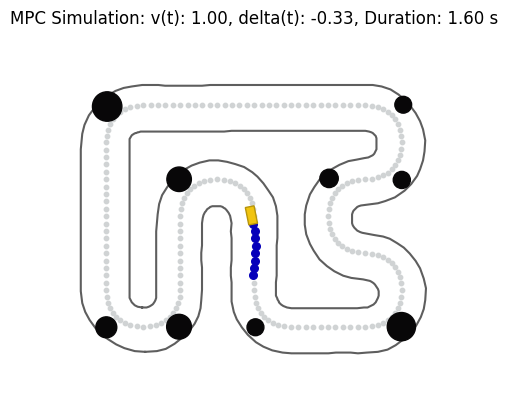

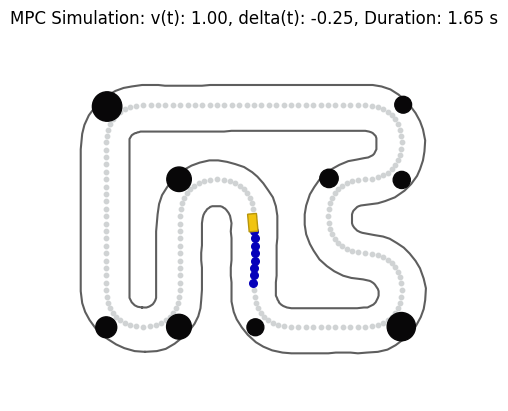

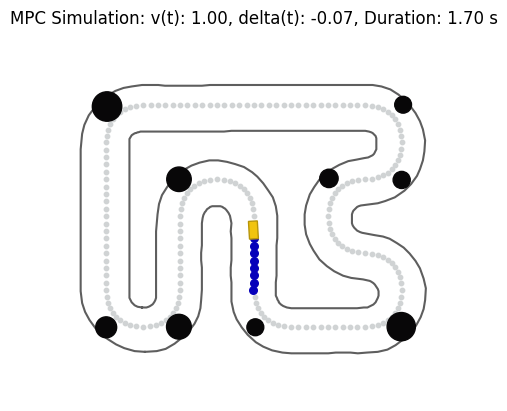

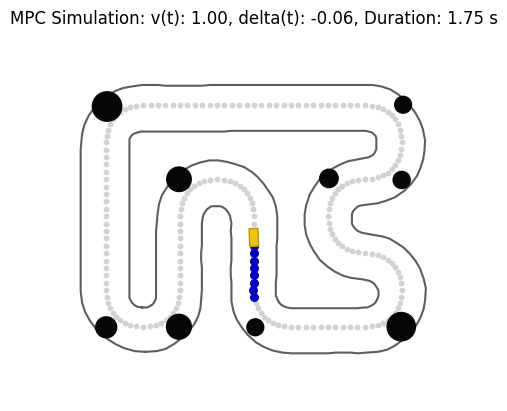

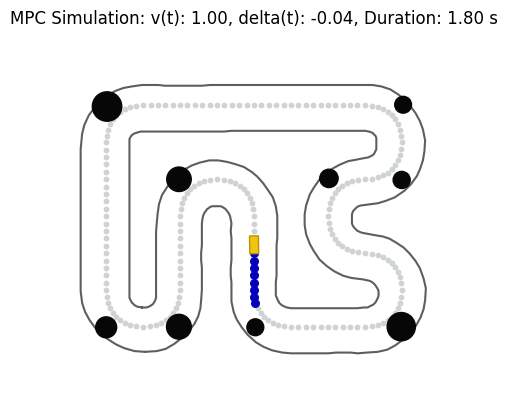

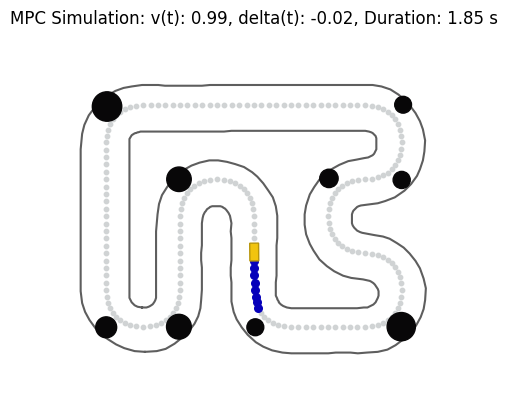

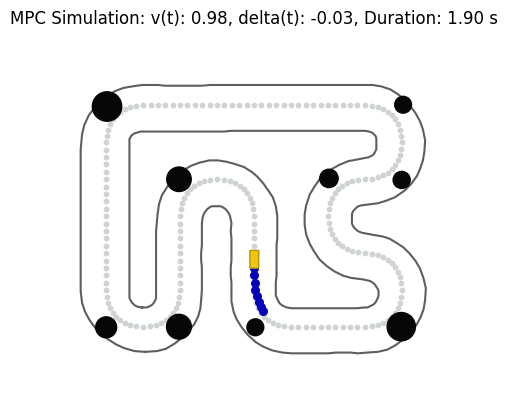

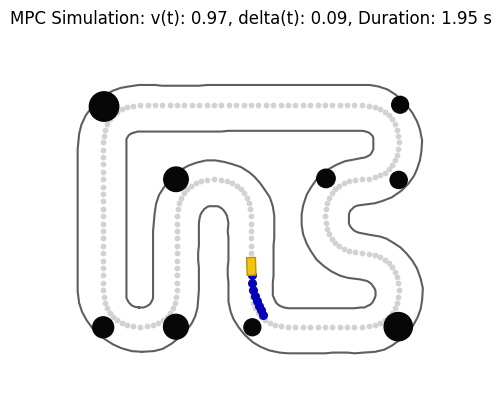

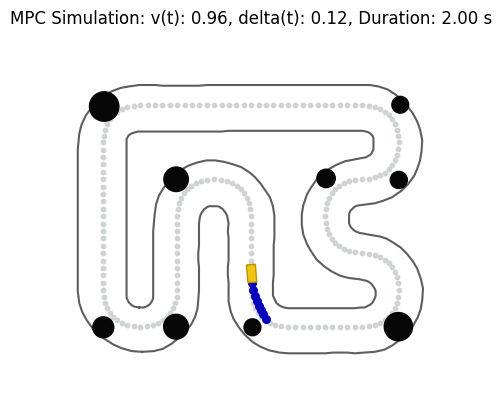

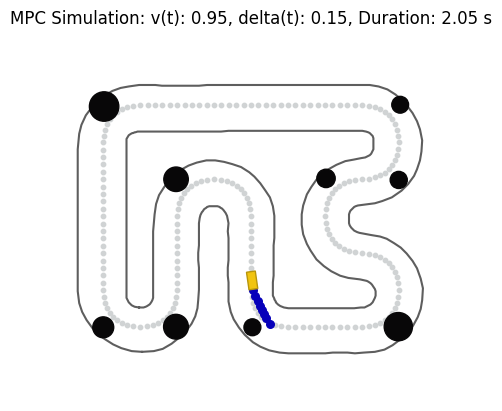

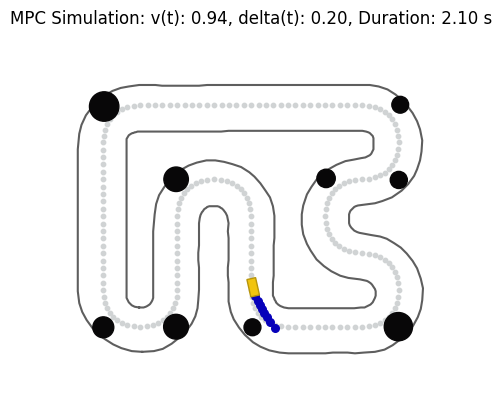

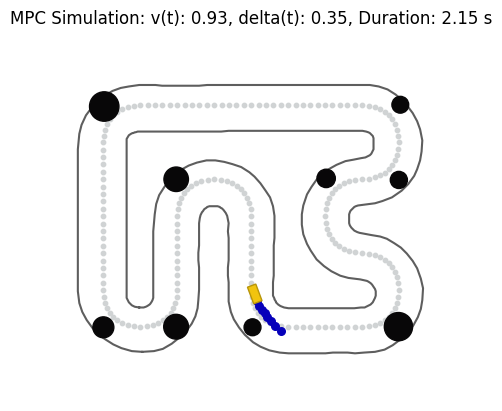

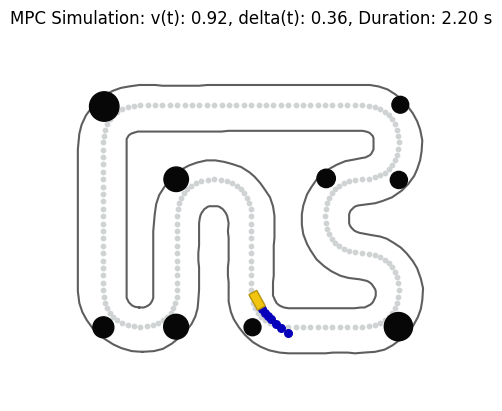

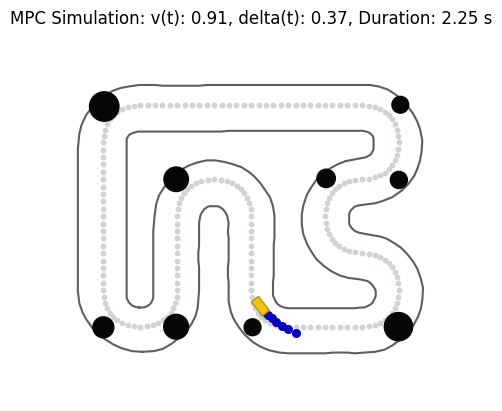

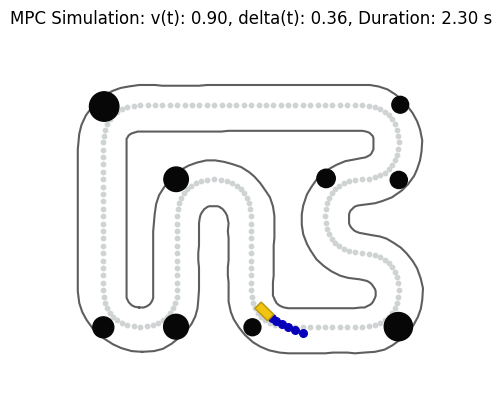

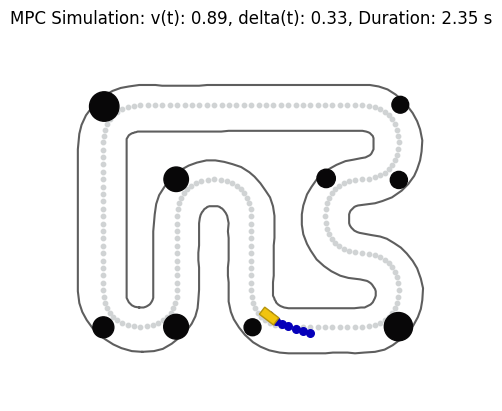

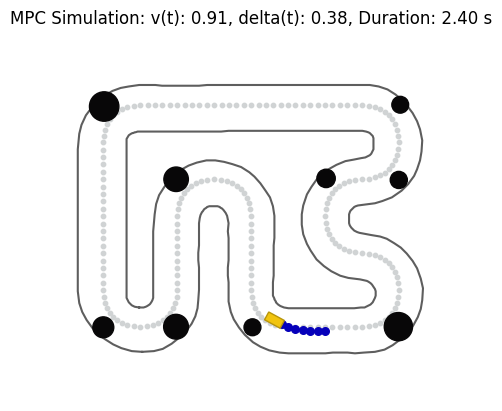

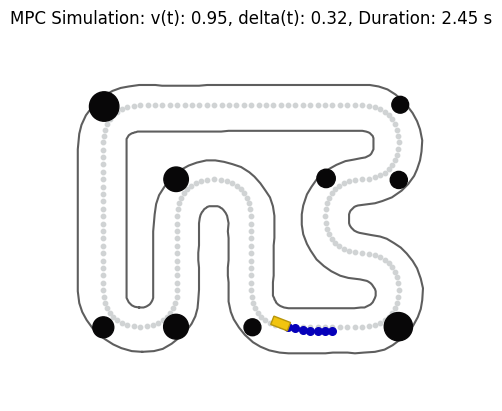

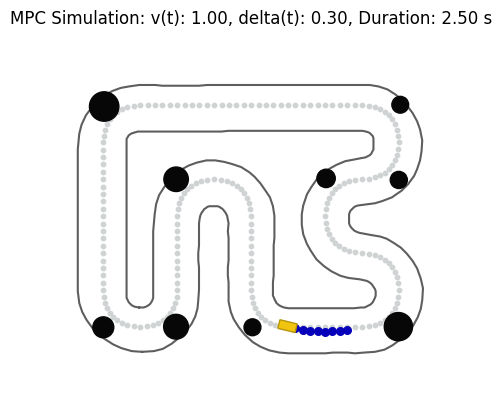

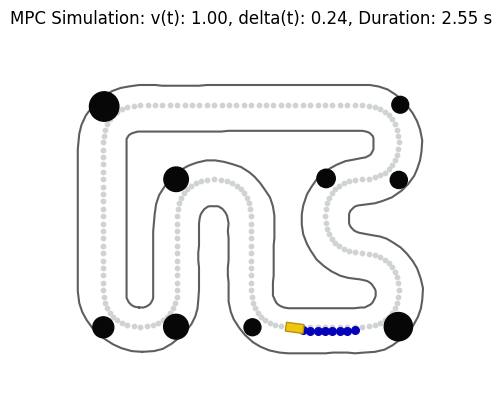

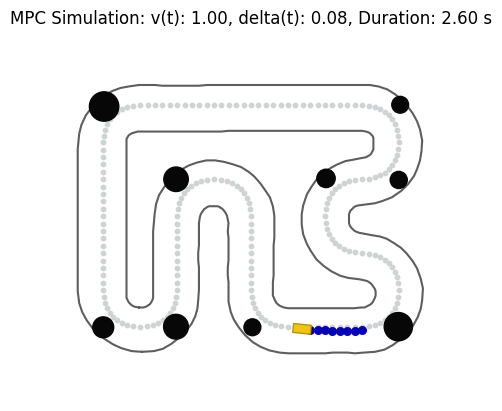

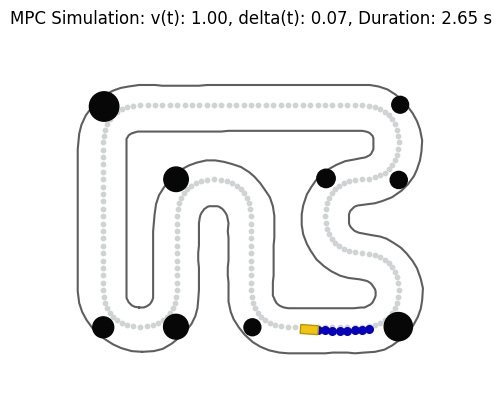

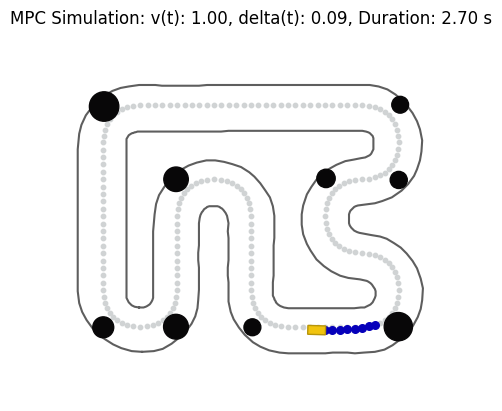

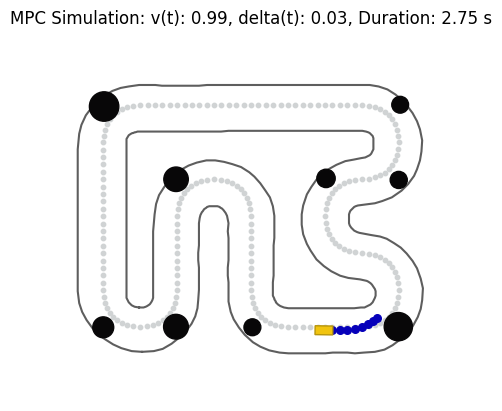

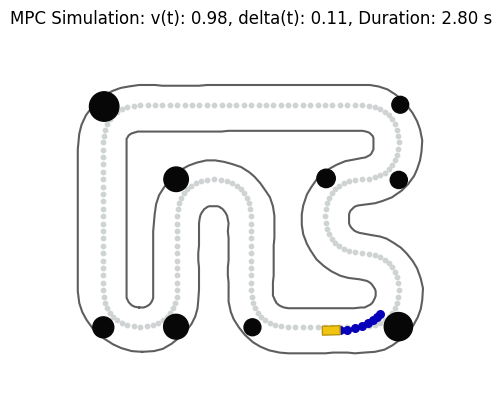

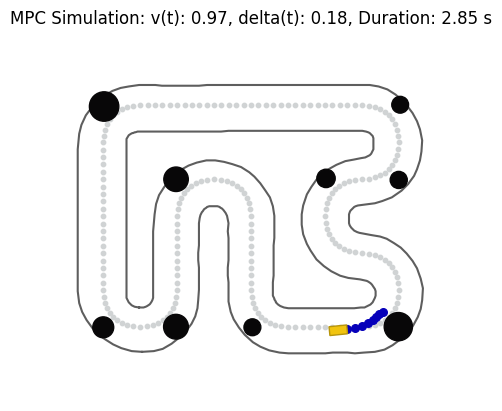

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from MPC import MPC
import random

if __name__ == '__main__':

    # Select Simulation Mode | 'Sim_Track' or 'Real_Track'
    sim_mode = 'Sim_Track'

    # Simulation Environment. Mini-Car on track specifically designed to show-
    # case time-optimal driving.
    if sim_mode == 'Sim_Track':

        # Load map file
        map = Map(file_path='sim_map.png', origin=[-1, -2],
                  resolution=0.005)

        # Specify waypoints
        wp_x = [-0.75, -0.25, -0.25, 0.25, 0.25, 1.25, 1.25, 0.75, 0.75, 1.25,
                1.25, -0.75, -0.75, -0.25]
        wp_y = [-1.5, -1.5, -0.5, -0.5, -1.5, -1.5, -1, -1, -0.5, -0.5, 0, 0,
                -1.5, -1.5]

        # Specify path resolution
        path_resolution = 0.05  # m / wp

        # Create smoothed reference path
        reference_path = ReferencePath(map, wp_x, wp_y, path_resolution,
                                       smoothing_distance=5, max_width=0.23,
                                       circular=True)

        # Add obstacles
        use_obstacles = True
        if use_obstacles:
            # obs1 = Obstacle(cx=0.0, cy=0.0, radius=0.05)
            # obs2 = Obstacle(cx=-0.8, cy=-0.5, radius=0.08)
            # obs3 = Obstacle(cx=-0.7, cy=-1.5, radius=0.05)
            # obs4 = Obstacle(cx=-0.3, cy=-1.0, radius=0.08)
            # obs5 = Obstacle(cx=0.27, cy=-1.0, radius=0.05)
            # obs6 = Obstacle(cx=0.78, cy=-1.47, radius=0.05)
            # obs7 = Obstacle(cx=0.73, cy=-0.9, radius=0.07)
            # obs8 = Obstacle(cx=1.2, cy=0.0, radius=0.08)
            # obs9 = Obstacle(cx=0.67, cy=-0.05, radius=0.06)
            # map.add_obstacles([obs1, obs2, obs3, obs4, obs5, obs6, obs7,
            #                               obs8, obs9])
            # Compression reference point
            reference_points = list(zip(wp_x, wp_y))

            # Randomly select 10 reference points
            selected_reference_points = random.sample(reference_points, 10)

            # Create obstacles around each selected point
            obstacles = []
            for x, y in selected_reference_points:
                obstacle = map.generate_random_obstacle(x, y)
                obstacles.append(obstacle)

            # Add obstacles to the map
            map.add_obstacles(obstacles)

        # Instantiate motion model
        car = BicycleModel(length=0.12, width=0.06,
                           reference_path=reference_path, Ts=0.05)


    ##############
    # Controller #
    ##############

    N = 10
    Q = sparse.diags([1.0, 0.0, 0.0])
    R = sparse.diags([0.5, 0.0])
    QN = sparse.diags([1.0, 0.0, 0.0])

    Q = np.array(sparse.diags([1.0, 0.0, 0.0]).toarray())
    R = np.array(sparse.diags([0.5, 0.0]).toarray())
    QN = np.array(sparse.diags([1.0, 0.0, 0.0]).toarray())

    v_max = 1.0  # m/s
    delta_max = 0.66  # rad
    ay_max = 4.0  # m/s^2
    InputConstraints = {'umin': np.array([0.0, -np.tan(delta_max)/car.length]),
                        'umax': np.array([v_max, np.tan(delta_max)/car.length])}
    StateConstraints = {'xmin': np.array([-np.inf, -np.inf, -np.inf]),
                        'xmax': np.array([np.inf, np.inf, np.inf])}
    mpc = MPC(car, N, Q, R, QN, StateConstraints, InputConstraints, ay_max)

    # Compute speed profile
    a_min = -0.1  # m/s^2
    a_max = 0.5  # m/s^2
    SpeedProfileConstraints = {'a_min': a_min, 'a_max': a_max,
                               'v_min': 0.0, 'v_max': v_max, 'ay_max': ay_max}
    car.reference_path.compute_speed_profile(SpeedProfileConstraints)

    ##############
    # Simulation #
    ##############

    # Set simulation time to zero
    t = 0.0

    # Logging containers
    x_log = [car.temporal_state.x]
    y_log = [car.temporal_state.y]
    v_log = [0.0]

    # Until arrival at end of path
    while car.s < reference_path.length:

        # Get control signals
        u = mpc.get_control()

        # Simulate car
        car.drive(u)

        # Log car state
        x_log.append(car.temporal_state.x)
        y_log.append(car.temporal_state.y)
        v_log.append(u[0])

        # Increment simulation time
        t += car.Ts

        # Plot path and drivable area
        reference_path.show()

        # Plot car
        car.show()

        # Plot MPC prediction
        mpc.show_prediction()

        # Set figure title
        plt.title('MPC Simulation: v(t): {:.2f}, delta(t): {:.2f}, Duration: '
                  '{:.2f} s'.format(u[0], u[1], t))
        plt.axis('off')
        plt.pause(0.001)
